In [1]:
from torchvision.models import resnet50, ResNet50_Weights
%matplotlib inline

from PIL import Image,ImageChops
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk
import numpy as np
import skimage.transform

from torchvision import datapoints
from torchvision.io import read_image
import torch
import numpy as np

from typing import Callable, Optional
import torch

from imagenet_labels import labels
%load_ext autoreload
%autoreload 2

/opt/homebrew/Caskroom/miniconda/base/envs/torch/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)


In [2]:
# Best available weights (currently alias for IMAGENET1K_V2)
# Note that these weights may change across versions
net = resnet50(weights=ResNet50_Weights.DEFAULT)

## 1.1: Download code for class activation mapping (CAM and/or grad-CAM)

In [3]:
# Imagenet mean/std

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

# Preprocessing - scale to 224x224 for model, convert to tensor, 
# and normalize to -1..1 with mean/std for ImageNet

preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

display_transform = transforms.Compose([
   transforms.Resize((224,224))])

In [4]:
model = net
# model = models.resnet50(pretrained=True)
#model.cuda()
model.eval()
print()

In [5]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

final_layer = model._modules.get('layer4')
activated_features = SaveFeatures(final_layer)

In [53]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

weight_softmax_params

def imageWithCam(imgPath, requires_grad=True, nofPred=1,
                 ax = None, overlay = True):
    """
    Plots the image with cam
    """
    if ax is None:
        fig, ax = plt.subplots(dpi=300)
    
    if isinstance(imgPath, str):
        image = Image.open(imgPath)
    else:
        image = imgPath
        
    if np.array(image).shape[2]==4:
        image = image.convert('RGB')
   
    # Reinstantiate the model 
    model = net
    model.eval()
    final_layer = model._modules.get('layer4')
    activated_features = SaveFeatures(final_layer)

    tensor = preprocess(image)

    prediction_var = Variable((tensor.unsqueeze(0)), requires_grad)
    prediction = model(prediction_var)
    pred_probabilities = F.softmax(prediction).data.squeeze()
    activated_features.remove()
    #print(topk(pred_probabilities,nofPred))
    class_idx = topk(pred_probabilities,nofPred)[1].int()
    #print(class_idx)
    overlay = getCAM(activated_features.features, weight_softmax, class_idx[nofPred-1])
    # Print the predicted label
    #print(f"Predicted label: {labels[class_idx]}")

    #print(class_idx[nofPred-1])
    if overlay:
        ax.imshow(overlay[0], alpha=0.5, cmap='jet')
        ax.imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet')
        
    ax.imshow(display_transform(image))
    
    ax.set_title(f"Predicted label: {labels[class_idx]}", size=9)

    return ax
  #return fig

## 1.2. Get 3 images from the internet and see how the attention maps for the prediction of the network change

In [8]:
# Set base path for imgs
base_path = "cam_imgs"

imgs = {
    "zebra":f"{base_path}/zebra.jpg",
    "pipe_organ":f"{base_path}/pipe_organ.jpg",
    "piggy_bank":f"{base_path}/piggy_bank.jpg",
    #"group_1": f"{base_path}/group_photo_1.png",
    #"group_2": f"{base_path}/group_photo_2.png"
}


In [ ]:
fig, axs = plt.subplots(ncols=len(imgs), dpi =300)
for i, (name, img) in enumerate(imgs.items()):
    
    imageWithCam(img, requires_grad=True, nofPred=1, ax = axs[i])
    axs[i].axis("off")
    #axs[i].set_title("Predicted label: 
    
plt.tight_layout()
plt.show()

### 1.2.1: Affine Image transformations, i.e., rotation, flipping, shift etc.

In [9]:
torch.manual_seed(123)
transform1 = transforms.Compose(
    [
        transforms.RandomRotation(180),
    ]
)

### 1.2.2: Additive noise, i.e., salt and pepper noise, gaussian filtering, median blur, unsharp filter

In [10]:
import torch
def add_gaussian_noise(y, mean=0, std=150/255):
    # x = np.array(y)
    # print(type(x))
    noise = torch.randn(y.shape) * std + mean
    return (y + noise).clamp(0, 1) # * 255

transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: add_gaussian_noise(x, mean=0, std=150/255)),
    transforms.ToPILImage()
])



### 1.2.3: Intensity transformation, i.e, flipping the RGB channels, histogram equalization 

In [11]:
def flipRGB(image):
    print(image.shape)
    image_new  = image[[2,1,0],...]
    return image_new

transform3 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: flipRGB(x)),
    transforms.ToPILImage(),
])


# Example usage
def affine_img(ori_image,transform=transform1):
    image = ori_image
    image = read_image(str(image))
    image = np.transpose(image.numpy(), (1, 2, 0))
    image = Image.fromarray(image)
    image1_new1 = transform(image)
    # imshow(ImageChops.subtract(image1_new1, image))
    # imshow(np.array(image1_new1)-np.array(image))
    print(np.array(image1_new1).shape)
    return image1_new1

/var/folders/th/25k92shs62s6010hztc3mf9w0000gn/T/ipykernel_19398/3578279509.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_probabilities = F.softmax(prediction).data.squeeze()


(667, 1000, 3)
(4000, 3000, 3)
(340, 520, 3)
(667, 1000, 3)
(4000, 3000, 3)
(340, 520, 3)
torch.Size([3, 667, 1000])
(667, 1000, 3)
torch.Size([3, 4000, 3000])
(4000, 3000, 3)
torch.Size([3, 340, 520])
(340, 520, 3)


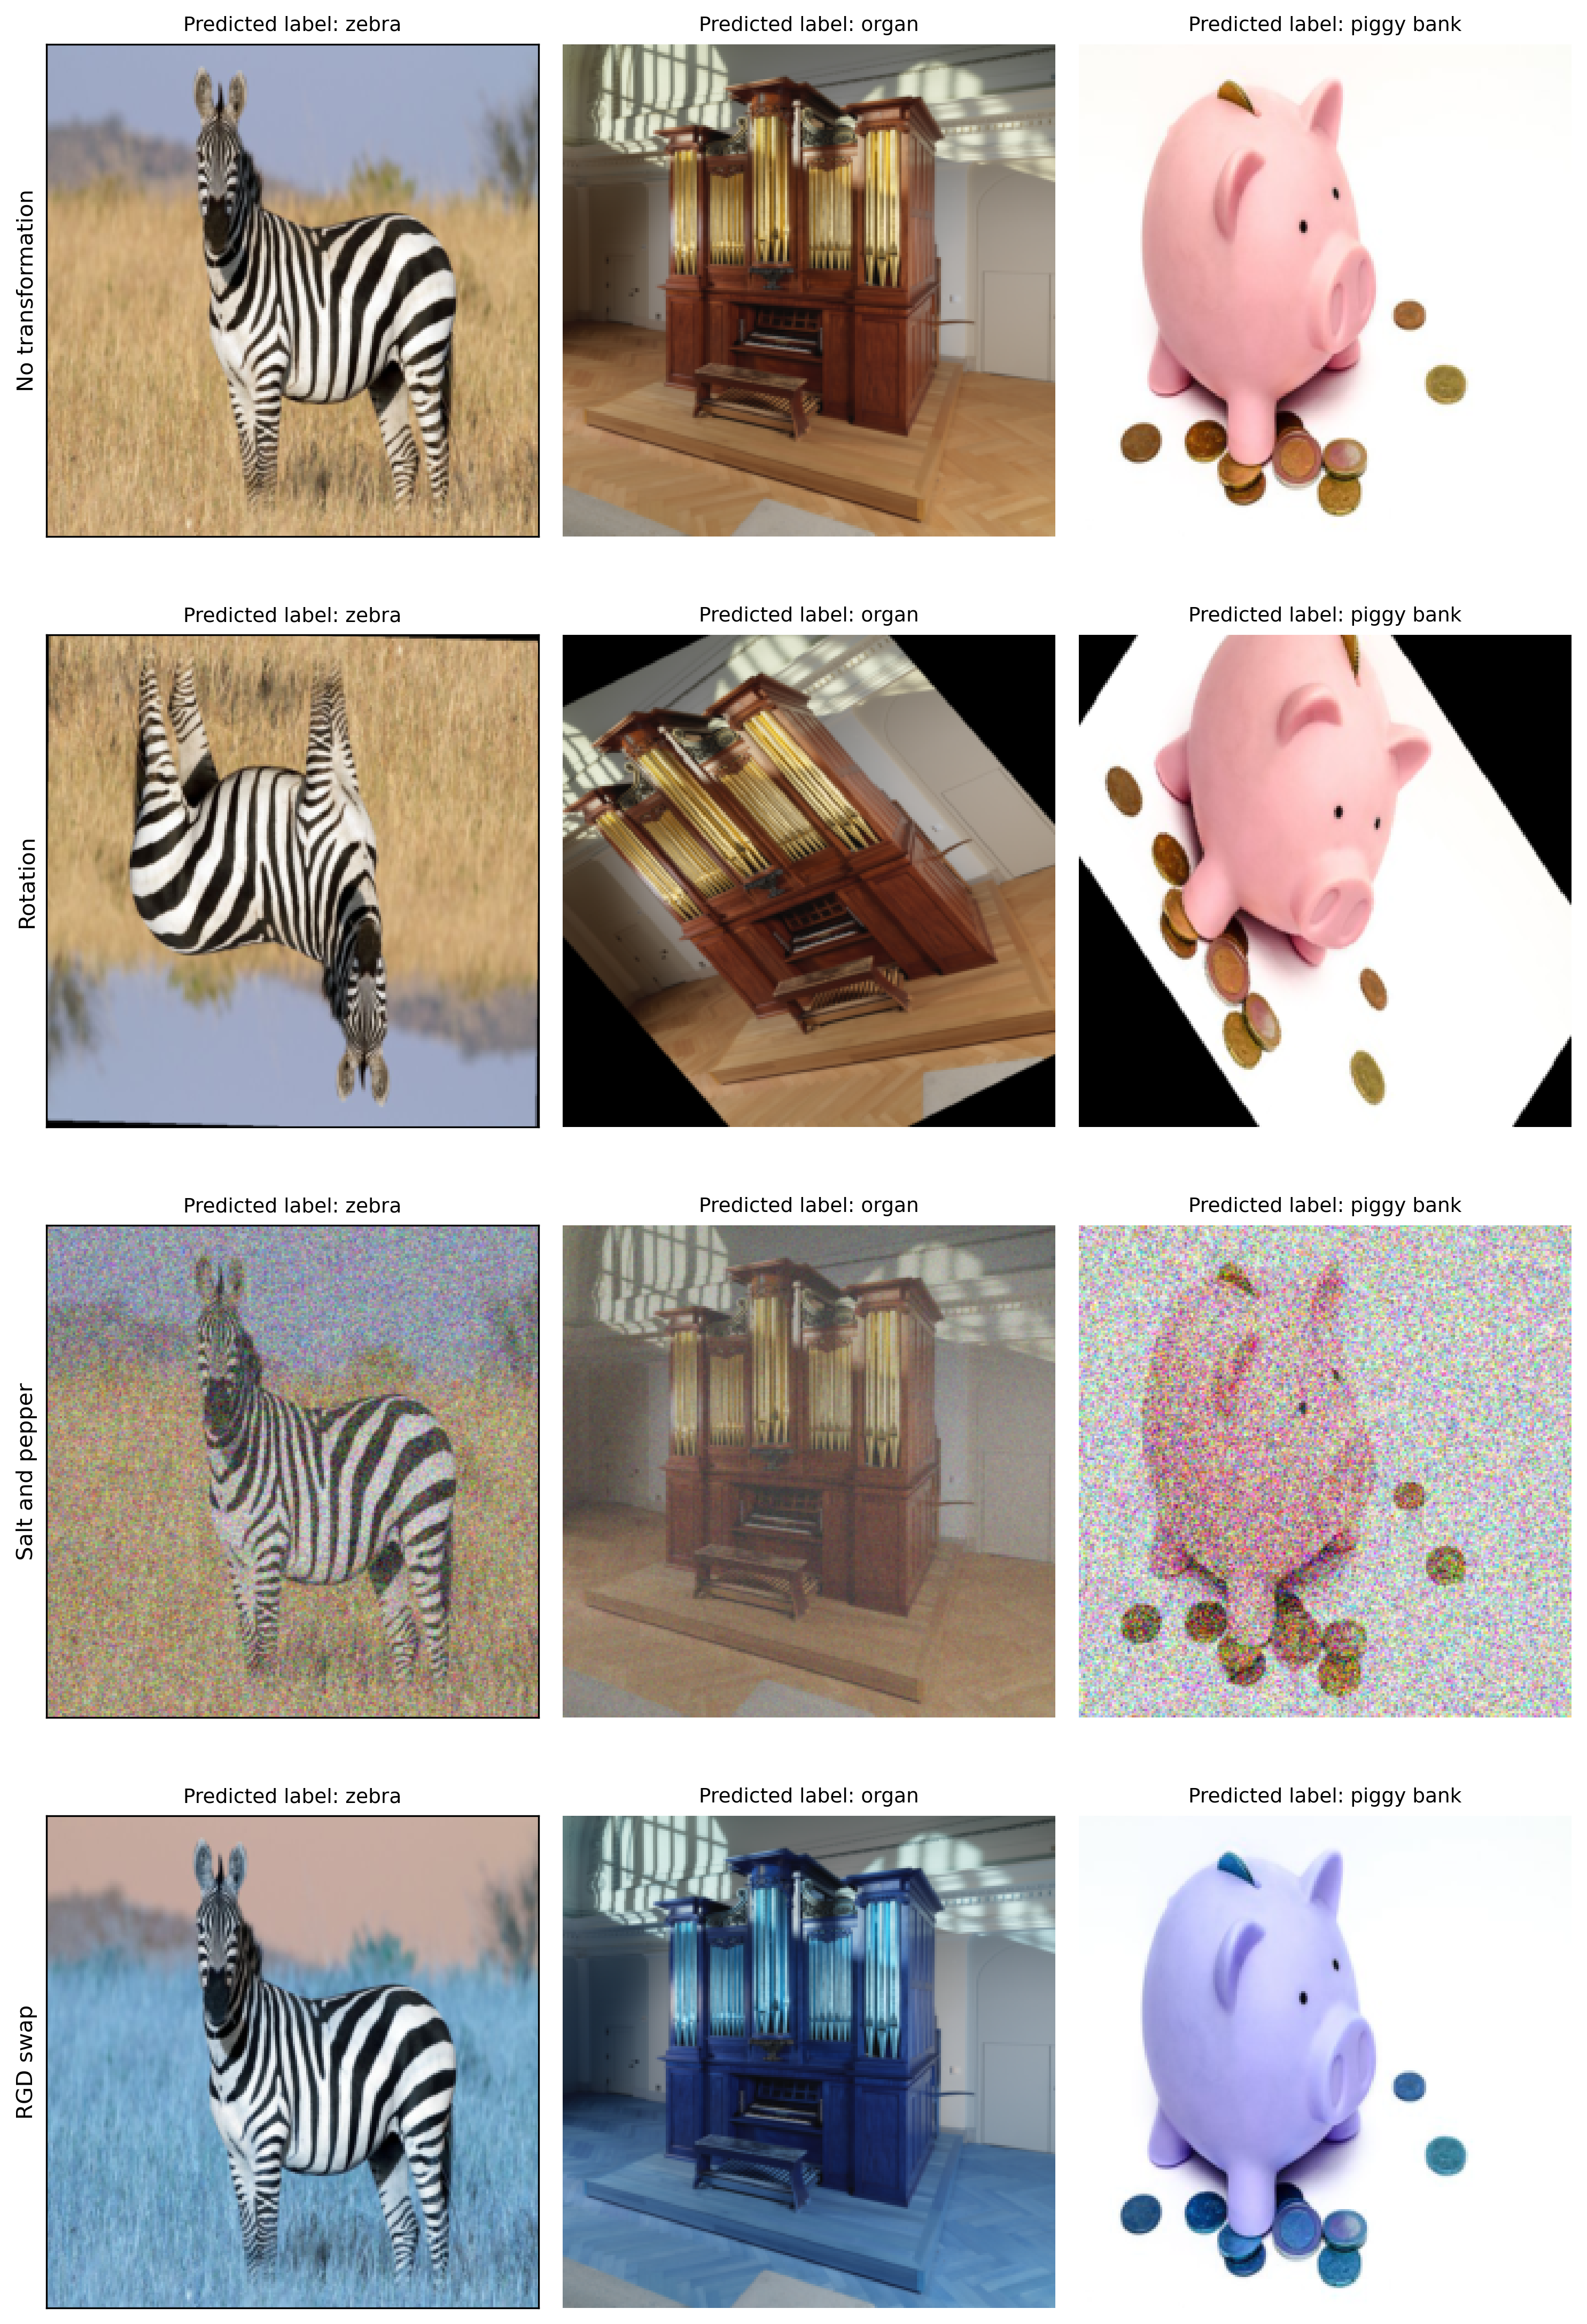

In [54]:
fig, axs = plt.subplots(ncols=len(imgs), nrows=4, dpi =300, figsize=(10, 15))
for i, (trans_type, transformation) in enumerate(zip(["No transformation", "Rotation", "Salt and pepper", "RGD swap"], 
                                                   [None, transform1, transform2, transform3])):
    
    for j, (name, img) in enumerate(imgs.items()):
       # print(name)
    

        if transformation is not None:
            img = affine_img(imgs[name], transformation)
        #print(type(img))
        imageWithCam(img, requires_grad=True, nofPred=1, ax = axs[i][j], overlay=False)
        
        if j == 0:
            axs[i][j].set_ylabel(trans_type)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        #else:
            axs[i][j].axis("off")

fig.tight_layout()
plt.savefig("figs/transformed_grid.pdf")

/var/folders/th/25k92shs62s6010hztc3mf9w0000gn/T/ipykernel_19398/821328780.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_probabilities = F.softmax(prediction).data.squeeze()


(667, 1000, 3)
(4000, 3000, 3)
(340, 520, 3)
(667, 1000, 3)
(4000, 3000, 3)
(340, 520, 3)
torch.Size([3, 667, 1000])
(667, 1000, 3)
torch.Size([3, 4000, 3000])
(4000, 3000, 3)
torch.Size([3, 340, 520])
(340, 520, 3)


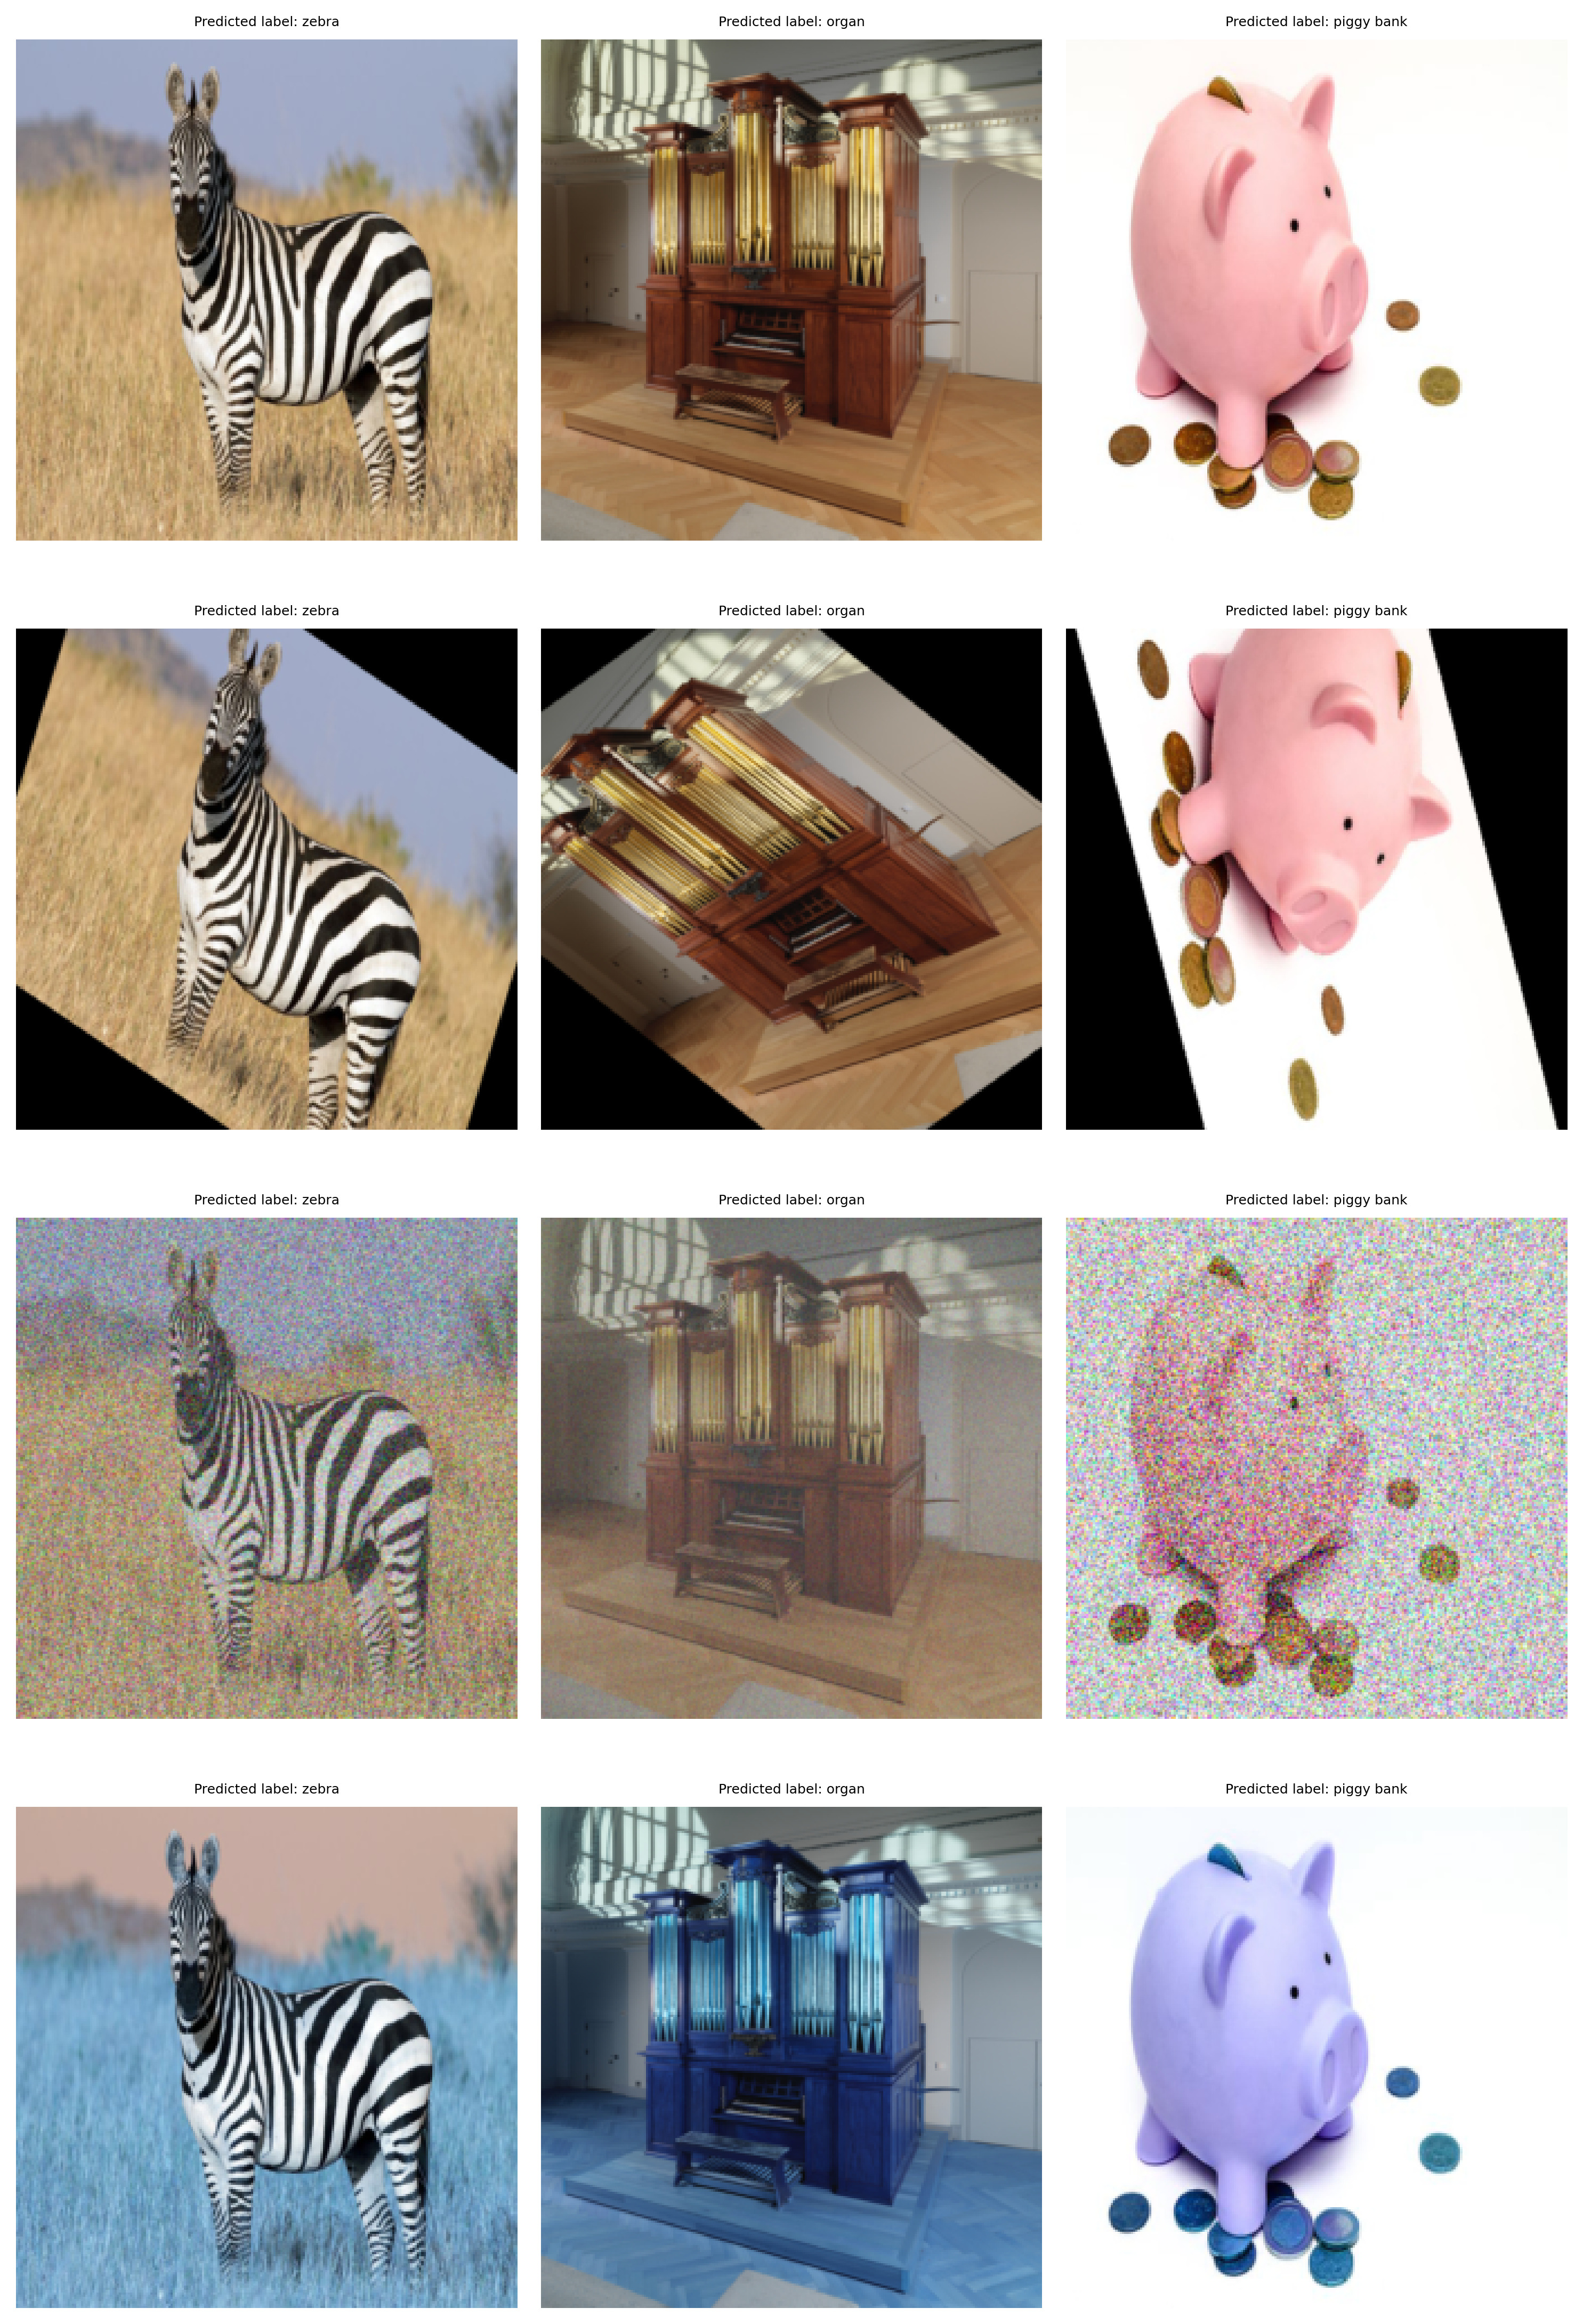

In [43]:
fig, axs = plt.subplots(ncols=len(imgs), nrows=4, dpi =300, figsize=(10, 15))
for i, transformation in enumerate([None, transform1, transform2, transform3]):
    
    for j, (name, img) in enumerate(imgs.items()):
       # print(name)
    

        if transformation is not None:
            img = affine_img(imgs[name], transformation)
        #print(type(img))
        imageWithCam(img, requires_grad=True, nofPred=1, ax = axs[i][j], overlay=True)
        axs[i][j].axis("off")

fig.tight_layout()
plt.savefig("figs/transformed_overlay_grid.pdf")

## 1.3: Repeat the above task for Layer-wise relevance propagation LRP (see links below). Comment on the usefulness of the different techniques.

## 1.4: On a team photo, who gets most attention?